# Proyecto
## 1. Extracción y análisis de la base de datos Colfondos

En este notebook se documenta paso a paso la extracción, limpieza y análisis inicial
del dataset público de Colfondos disponible en [datos.gov.co](https://www.datos.gov.co/).


## 2. Importamos las librerías que vamos a usar para análizar el dataset

In [8]:
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os


## 3. Conexión a la API

El dataset se encuentra en la plataforma Socrata, y por defecto devuelve
máximo 1000 filas. Para obtener todo el dataset, se usa paginación
con los parámetros `$limit` y `$offset`.


In [9]:
BASE = "https://www.datos.gov.co"
RESOURCE = "uawh-cjvi"
URL = f"{BASE}/resource/{RESOURCE}.json"

try:
    total_filas = int(requests.get(f"{URL}?$select=count(*)").json()[0]["count"])
except Exception:
    total_filas  = None
print("Total reportado:", total_filas )

Total reportado: 89188


### 4. Descarga de datos en páginas
Usamos un bucle `while` para traer todas las filas de la base,
concatenando los resultados en un único Diccionario.


In [10]:
Lista_paginas = []
limit = 50000
offset = 0
while True:
    params = {"$limit": limit, "$offset": offset}
    r = requests.get(URL, params=params, timeout=120)
    r.raise_for_status()
    respuestaJson = r.json()
    if not respuestaJson: # fin de datos
        break
    Lista_paginas.append(pd.DataFrame(respuestaJson))
    offset += limit
    print(f"Descargadas: {offset} filas…")
    time.sleep(0.3)

if Lista_paginas:
    df = pd.concat(Lista_paginas, ignore_index=True)
else:
    df = pd.DataFrame()

Descargadas: 50000 filas…
Descargadas: 100000 filas…


## 5. Exploración inicial
Mostramos las primeras filas y las columnas disponibles en el dataset.



In [11]:
df.head()
df.info()
df.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89188 entries, 0 to 89187
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   fecha              89188 non-null  object
 1   codigo_entidad     89188 non-null  object
 2   nombre_entidad     89188 non-null  object
 3   codigo_patrimonio  89188 non-null  object
 4   nombre_fondo       89188 non-null  object
 5   valor_unidad       89188 non-null  object
dtypes: object(6)
memory usage: 4.1+ MB


,fecha,codigo_entidad,nombre_entidad,codigo_patrimonio,nombre_fondo,valor_unidad
count,89188,89188,89188,89188,89188,89188
unique,3568,4,4,7,7,88397
top,2025-09-21T00:00:00.000,9,Skandia Afp - Accai S.A.,1,Fondo de Cesantias Largo Plazo,29983.110000
freq,25,24976,24976,14270,14270,3


## 6. Limpieza de datos
6.1. Convertimos las fechas al tipo `datetime` y el valor de la unidad a `float`.


In [12]:
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df["valor_unidad"] = (
    df["valor_unidad"]
      .astype(str)
      .str.replace(r"[^\d\-,\.]", "", regex=True)
      .str.replace(",", ".", regex=False)
      .astype(float)
)
df.dtypes

# Create the directory if it doesn't exist
Path("data/raw").mkdir(parents=True, exist_ok=True)

df.to_csv("data/raw/pensionesLimpio.csv", index=False)

6.2. Vamos a ver si hay valores nulos en el diccionario que contiene todos los datos del dataset:

In [13]:
nulls = df.isna().mean().sort_values(ascending=False).mul(100).round(2)
print(nulls)

fecha                0.0
codigo_entidad       0.0
nombre_entidad       0.0
codigo_patrimonio    0.0
nombre_fondo         0.0
valor_unidad         0.0
dtype: float64


En nuestro caso, no hay datos nulos, por lo tanto, no se deben borrar filas por este motivo.

6.3. Nos interesa saber la cardinalidad de cada columna, y tambien ver cuales son los valores distintos de ciertas columnas:

In [14]:
cardinalidad = df.nunique(dropna=True).sort_values(ascending=False)
print(cardinalidad)
print(df["nombre_entidad"].value_counts(dropna=False).head(10))
print(df["nombre_fondo"].value_counts(dropna=False).head(20))

print(df.groupby("codigo_entidad")["nombre_entidad"].nunique().sort_values(ascending=False).head())
print(df.groupby("codigo_patrimonio")["nombre_fondo"].nunique().sort_values(ascending=False).head())

print(df.groupby("nombre_entidad")["codigo_entidad"].nunique().sort_values(ascending=False).head())
print(df.groupby("nombre_fondo")["codigo_patrimonio"].nunique().sort_values(ascending=False).head())


valor_unidad         88397
fecha                 3568
nombre_fondo             7
codigo_patrimonio        7
codigo_entidad           4
nombre_entidad           4
dtype: int64
nombre_entidad
Skandia Afp - Accai S.A.          24976
"Colfondos S.A." Y "Colfondos"    21408
"Porvenir"                        21402
"Proteccion"                      21402
Name: count, dtype: int64
nombre_fondo
Fondo de Cesantias Largo Plazo          14270
Fondo de Cesantias Corto Plazo          14270
Fondo de Pensiones Moderado             14270
Fondo de Pensiones Conservador          14270
Fondo de Pensiones Mayor Riesgo         14270
Fondo de Pensiones Retiro Programado    14270
Fondo de Pensiones Alternativo           3568
Name: count, dtype: int64
codigo_entidad
10    1
2     1
3     1
9     1
Name: nombre_entidad, dtype: int64
codigo_patrimonio
1       1
1000    1
2       1
5000    1
6000    1
Name: nombre_fondo, dtype: int64
nombre_entidad
"Colfondos S.A." Y "Colfondos"    1
"Porvenir"                   

Con esto nos damos cuenta de que las columnas codigo_entidad y nombre_entidad estan relacionadas, y tambien las columnas codigo_patrimonio y nombre_fondo, a traves de una correspondencia uno a uno, lo cual significa que sera util remover dos columnas, codigo_entidad y codigo_patrimonio, para trabajar con valores relevantes.

6.5. Luego vamos a crear un diccionario con key el nombre_entidad y value el codigo_entidad y otro diccionario con key el nombre_fondo y value codigo_patrimonio.

In [15]:
dict_entidad = (
    df[["nombre_entidad", "codigo_entidad"]]
    .drop_duplicates()
    .set_index("nombre_entidad")["codigo_entidad"]
    .to_dict()
)

# Diccionario fondo (nombre → código)
dict_fondo = (
    df[["nombre_fondo", "codigo_patrimonio"]]
    .drop_duplicates()
    .set_index("nombre_fondo")["codigo_patrimonio"]
    .to_dict()
)



para luego crear un archivo csv con el contenido de los diccionarios.

In [16]:
dict_entidad = df[["nombre_entidad", "codigo_entidad"]].drop_duplicates().set_index("nombre_entidad")["codigo_entidad"].to_dict()
dict_fondo = df[["nombre_fondo", "codigo_patrimonio"]].drop_duplicates().set_index("nombre_fondo")["codigo_patrimonio"].to_dict()

## 7. Identificación de columnas irrelevantes
Exploramos valores únicos en `nombre_entidad` y `nombre_fondo` para
decidir qué columnas conservar.

In [17]:
print("Valores únicos en nombre_entidad:", df["nombre_entidad"].unique())
print("Valores únicos en nombre_fondo:", df["nombre_fondo"].unique()[:10])

print(df["nombre_entidad"].value_counts())
print(df["nombre_fondo"].value_counts().head(20))


Valores únicos en nombre_entidad: ['"Proteccion"' '"Porvenir"' 'Skandia Afp - Accai S.A.'
 '"Colfondos S.A." Y "Colfondos"']
Valores únicos en nombre_fondo: ['Fondo de Cesantias Largo Plazo' 'Fondo de Cesantias Corto Plazo'
 'Fondo de Pensiones Moderado' 'Fondo de Pensiones Conservador'
 'Fondo de Pensiones Mayor Riesgo' 'Fondo de Pensiones Retiro Programado'
 'Fondo de Pensiones Alternativo']
nombre_entidad
Skandia Afp - Accai S.A.          24976
"Colfondos S.A." Y "Colfondos"    21408
"Porvenir"                        21402
"Proteccion"                      21402
Name: count, dtype: int64
nombre_fondo
Fondo de Cesantias Largo Plazo          14270
Fondo de Cesantias Corto Plazo          14270
Fondo de Pensiones Moderado             14270
Fondo de Pensiones Conservador          14270
Fondo de Pensiones Mayor Riesgo         14270
Fondo de Pensiones Retiro Programado    14270
Fondo de Pensiones Alternativo           3568
Name: count, dtype: int64


## 8. Eliminamos las columnas irrelevantes.

Eliminamos las columnas nombre_entidad y nombre_fondo, ya que son irrelevantes.

In [18]:
df_limpio = df.drop(columns=["codigo_entidad", "codigo_patrimonio"])


y extraemos en un archivo csv los elementos de este DataFrame.

In [19]:
df_limpio.to_csv("data/raw/colfondosLimpio.csv", index=False)


Ahora, vamos a limpiar las columnas nombre_entidad y nombre_fondo.

In [20]:
for c in ["nombre_entidad", "nombre_fondo"]:
    df[c] = (df[c]
             .astype(str)
             .str.strip()
             .str.replace(r"\s+", " ", regex=True))
print(df[["nombre_entidad","nombre_fondo"]].nunique())

print("Valores únicos en nombre_entidad:", df["nombre_entidad"].unique())
print("Valores únicos en nombre_fondo:", df["nombre_fondo"].unique()[:10])

print(df["nombre_entidad"].value_counts())
print(df["nombre_fondo"].value_counts().head(20))



nombre_entidad    4
nombre_fondo      7
dtype: int64
Valores únicos en nombre_entidad: ['"Proteccion"' '"Porvenir"' 'Skandia Afp - Accai S.A.'
 '"Colfondos S.A." Y "Colfondos"']
Valores únicos en nombre_fondo: ['Fondo de Cesantias Largo Plazo' 'Fondo de Cesantias Corto Plazo'
 'Fondo de Pensiones Moderado' 'Fondo de Pensiones Conservador'
 'Fondo de Pensiones Mayor Riesgo' 'Fondo de Pensiones Retiro Programado'
 'Fondo de Pensiones Alternativo']
nombre_entidad
Skandia Afp - Accai S.A.          24976
"Colfondos S.A." Y "Colfondos"    21408
"Porvenir"                        21402
"Proteccion"                      21402
Name: count, dtype: int64
nombre_fondo
Fondo de Cesantias Largo Plazo          14270
Fondo de Cesantias Corto Plazo          14270
Fondo de Pensiones Moderado             14270
Fondo de Pensiones Conservador          14270
Fondo de Pensiones Mayor Riesgo         14270
Fondo de Pensiones Retiro Programado    14270
Fondo de Pensiones Alternativo           3568
Name: count, d

## 9. Crear nuevos datasets

Al tener un dataset limpio, y al saber que hay pocas entidades y fondos, podemos crear nuevos datasets por cada entidad y fondo, para luego comparar los resultados y analizar.

In [23]:
Path("data/raw").mkdir(parents=True, exist_ok=True)

def guardar_subset(df, col_filtro, valores, salida):
    if isinstance(valores, (list, tuple, set)):
        sub = df.loc[df[col_filtro].isin(valores)].copy()
    else:
        sub = df.loc[df[col_filtro].eq(valores)].copy()
    if col_filtro in sub.columns:
        sub = sub.drop(columns=[col_filtro])
    print(sub.shape)
    sub.to_csv(salida, index=False)

guardar_subset(df_limpio, "nombre_entidad",
               "Skandia Afp - Accai S.A.",
               "data/raw/pensiones_skandia.csv")

guardar_subset(df_limpio, "nombre_entidad",
               '"Proteccion"',
               "data/raw/pensiones_proteccion.csv")

guardar_subset(df_limpio, "nombre_entidad",
               '"Porvenir"',
               "data/raw/pensiones_porvenir.csv")

guardar_subset(df_limpio, "nombre_entidad",
               '"Colfondos S.A." Y "Colfondos"',
               "data/raw/colfondos_colfondos.csv")

guardar_subset(df_limpio, "nombre_fondo",
               "Fondo de Cesantias Largo Plazo",
               "data/raw/fondo_cesantias_largo_plazo.csv")

guardar_subset(df_limpio, "nombre_fondo",
               "Fondo de Cesantias Corto Plazo",
               "data/raw/fondo_cesantias_corto_plazo.csv")

guardar_subset(df_limpio, "nombre_fondo",
               "Fondo de Pensiones Moderado",
               "data/raw/fondo_pensiones_moderado.csv")

guardar_subset(df_limpio, "nombre_fondo",
               "Fondo de Pensiones Conservador",
               "data/raw/fondo_pensiones_conservador.csv")

guardar_subset(df_limpio, "nombre_fondo",
               "Fondo de Pensiones Mayor Riesgo",
               "data/raw/fondo_pensiones_mayor_riesgo.csv")

guardar_subset(df_limpio, "nombre_fondo",
               "Fondo de Pensiones Retiro Programado",
               "data/raw/fondo_pensiones_retiro_programado.csv")

guardar_subset(df_limpio, "nombre_fondo",
               "Fondo de Pensiones Alternativo",
               "data/raw/fondo_pensiones_alternativo.csv")

(24976, 3)
(21402, 3)
(21402, 3)
(21408, 3)
(14270, 3)
(14270, 3)
(14270, 3)
(14270, 3)
(14270, 3)
(14270, 3)
(3568, 3)


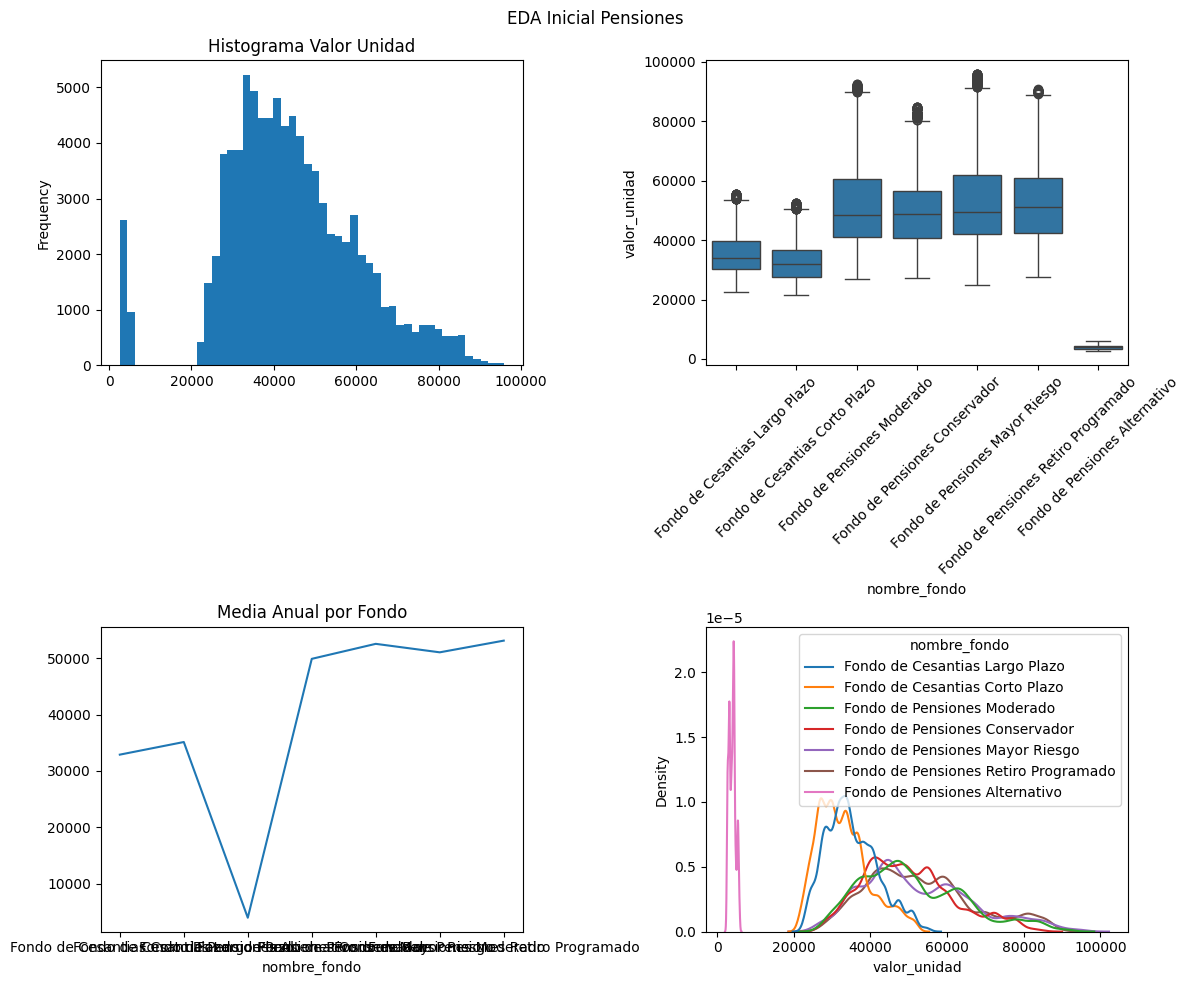

In [25]:
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
df['valor_unidad'].plot.hist(bins=50, ax=axes[0,0], title='Histograma Valor Unidad')
df.groupby('nombre_fondo')['valor_unidad'].mean().plot.line(ax=axes[1,0], title='Media Anual por Fondo')
sns.kdeplot(data=df, x='valor_unidad', hue='nombre_fondo', ax=axes[1,1])

# The boxplot requires a categorical variable, using 'nombre_fondo'
sns.boxplot(x='nombre_fondo', y='valor_unidad', data=df, ax=axes[0,1])
axes[0,1].tick_params(axis='x', rotation=45) # Rotate labels for readability

fig.suptitle('EDA Inicial Pensiones');
plt.tight_layout();
plt.show()